In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Database Connection
import psycopg2
from psycopg2 import sql, extras
import datetime
import os
import logging

logger = logging.getLogger(__name__)

class DatabaseConnection:
    def __init__(self):
        self.logger = logger
        try:
            self.connection = psycopg2.connect(
                dbname = "us_equity_markets",
                user = "r",
                password = "e0680963bb3ab8503de545f7e8fc71bc25918c909aaf13e32fb127fb8154cbcd",
                host = "db1",
                port = 5432
            )
            self.cursor = self.connection.cursor()
            self.logger.info("Database connection established.")
        
        except psycopg2.Error as e:
            self.logger.error(f'Error connecting to datase: {e}')
            raise e
    def connection_check(self):
        if self.connection:
            print("Database Connected Successfuly")
        else:
            print("Not Connected")
    def close(self):
        try:
            if self.cursor:
                self.cursor.close()
                self.logger.info('Database cursor closed.')
            if self.connection:
                self.connection.close()
                self.logger.info("Database connection closed.")
        except psycopg2.Error as e:
            self.logger.error(f"Error closing the database connection {e}")

    def select_stocks(self, ticker):
        query = """
        SELECT * FROM stocks.minute
        WHERE symbol = %s
        """
        with self.connection.cursor() as cursor:
            cursor.execute(query, (ticker,))
            rows = cursor.fetchall()
        # Each row: (id, symbol, time, open, high, low, close, volume)
        return rows

    def select_options_realtime(self, ticker):
        """
        Select option contract from the realtime options database. passing the dte and ticker

        """
        query = """
        SELECT * FROM options.realtime
        WHERE underlying = %s
        """
        with self.connection.cursor() as cursor:
            cursor.execute(query, (ticker,))
            rows = cursor.fetchall()
        return rows

db_conn = DatabaseConnection() 

Historical volatility is commonly taken to be the standard deviation of daily returns for the last calendar month.  There are other definitions one could use, however.  We will use the common definition and take one month to be 20 trading days.

If you look up the formula for standard deviation, you’ll find two forms given.

The first:
$$\sqrt{ \frac{1}{N} \sum_{i=1}^N(x_i - \mu)^2}$$
where $N$ is the number in the population, and $\mu$ is the population mean.

And:
$$\sqrt{ \frac{1}{n-1} \sum_{i=1}^n(x_i - \bar{x})^2}$$
where $n$ is the number of samples, and $\bar{x}$ is the sample mean.

Notice one divides by the number of points and other by one subtracted from the number of points.  I don’t want to get into the reason for this now, but unfortunately, Numpu and Pandas default to a different divisor.  The default behavior of both Pandas and Numpy can be overwritten by setting the <I>ddof</I> option.  Setting it to zero gives a divisor of $N$.  Setting it to one gives $N-1$, etc.  We will use $ddof=1$.

#  Pandas

The std function in Pandas sets ddof to one by defaul.

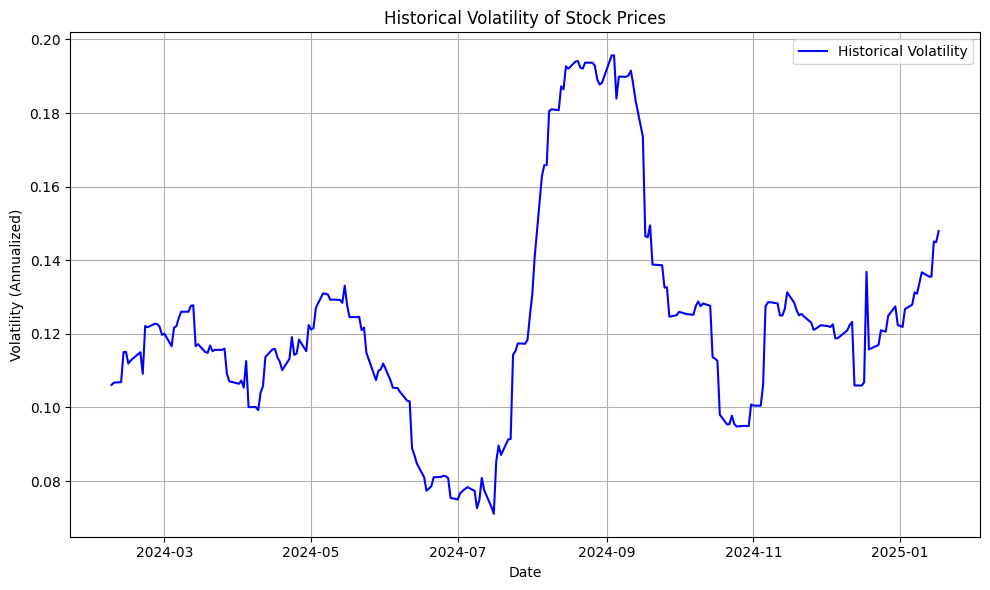

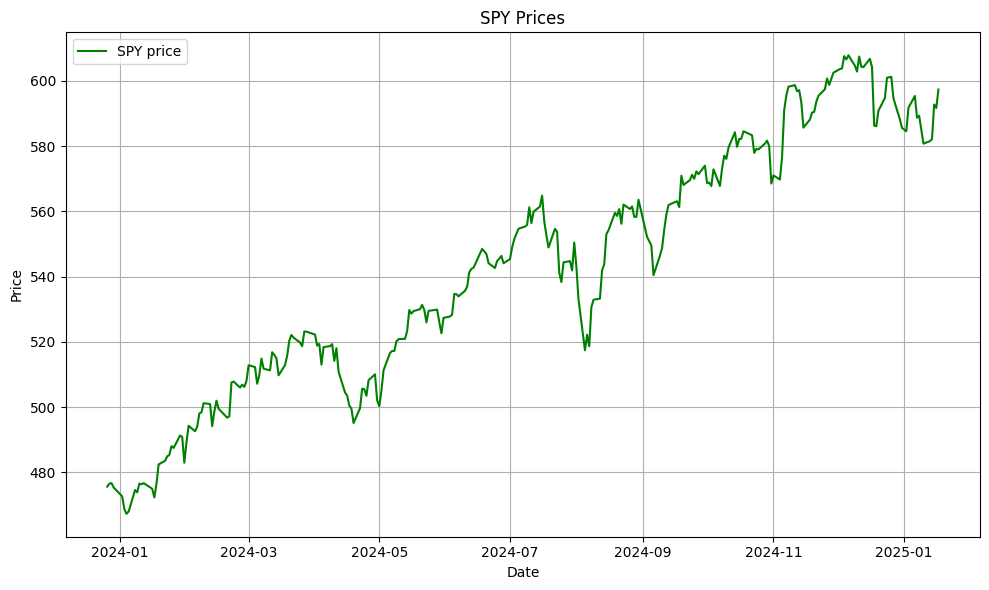

In [28]:
#  Import SPY data as a pandas data frame
SPY = pd.DataFrame(db_conn.select_stocks('SPY')).rename(columns={0: 'id', 1: 'ticker', 2: 'time', 3: 'open', 4:'high', 5: 'low', 6: 'close', 7: 'volume' }).set_index('time')
SPY = SPY.resample('1D').last().dropna()

#  Calculate the percent change of the price
SPY['PCT'] = SPY['close'].pct_change()

#  Remove the first value which is NaN
SPY_pct = SPY['PCT'].iloc[1:]

rolling_window = 30  # typically 20 trading days for monthly volatility
SPY['volatility'] = SPY['PCT'].rolling(window=rolling_window).std() * np.sqrt(252)  # 252 trading days in a year

# Plot the historical volatility
plt.figure(figsize=(10, 6))
plt.plot(SPY.index, SPY['volatility'], label='Historical Volatility', color='blue')
plt.title('Historical Volatility of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Volatility (Annualized)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(SPY.index, SPY['close'], label='SPY price', color='green')
plt.title('SPY Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

#  Numpy

By default, Numpy's std function sets ddof to zero.

In [11]:
#  Turn the pandas pct frame into a numpy array
spy_pct = SPY_pct.to_numpy()

#  Calculate the vol for the first 20 points.  We need to set ddof to one here as it defaults to zero
np.std( spy_pct[0:20], ddof = 1)

Decimal('0.005839008584600859753403573272')

We can use a loop to get the rest of the points

In [12]:
period = 20
vol_numpy = np.zeros( (spy_pct.size - period + 1, ))

for i in range(spy_pct.size - period + 1):
    vol_numpy[i] = np.std( spy_pct[i:i + period], ddof = 1)
    
print(vol_numpy)

[0.00583901 0.00586089 0.00603978 0.00598137 0.00701984 0.00714671
 0.00725374 0.00738354 0.006871   0.00695275 0.00692323 0.00693048
 0.00695267 0.0077281  0.0076631  0.00758648 0.00739038 0.00756488
 0.00755795 0.00872945 0.00870271 0.00876809 0.00865853 0.00866707
 0.00759735 0.00737787 0.00717266 0.00756197 0.00760331 0.00768979
 0.00788081 0.007832   0.00812215 0.0073496  0.00721951 0.00757128
 0.00753638 0.00741375 0.00757666 0.00621122 0.00624622 0.00621538
 0.00626551 0.006453   0.00644818 0.00619558 0.00639919 0.00589142
 0.00651952 0.00656094 0.00638564 0.00637426 0.00633857 0.0065625
 0.00728044 0.00745458 0.00729403 0.0072071  0.00676915 0.00680929
 0.00730141 0.00794989 0.00795026 0.00761371 0.00802665 0.00810247
 0.00866581 0.00865387 0.00864958 0.00879236 0.00913184 0.00913158
 0.00884091 0.0087696  0.00810881 0.00748099 0.00745742 0.00755984
 0.00756115 0.00706194 0.00694409 0.00660936 0.00668847 0.00689122
 0.00676242 0.00675955 0.00578081 0.00598202 0.0059505  0.00544

In [13]:
#  Are both pandas and numpy methods the same?
np.allclose(vol_pandas.to_numpy(), vol_numpy)

True